# Optimizing Classification Models

In this notebook, I'll explore ways to improve the three classifiers that performed the best across my vanilla models. I'll try obtaining optimal hyperparameters through GridSearch, expanding and shrinking my classes to fight class imbalance, and removing words that are highly correlated with certain classes and might lead to bias.

In [1]:
#Import libraries 

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk.corpus
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn import preprocessing
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

#Models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import string
import os
import regex as re

from capstone_functions import preprocess_title, evaluate_model, compare_models

import warnings
warnings.filterwarnings("ignore")

seed=293

In [2]:
# # HELPER FUNCTIONS

# def evaluate_model(model, X_test, y_test, X_train, y_train):
#     """
#     """

#     # Get predictions
#     y_hat_train = model.predict(X_train)
#     y_hat_test = model.predict(X_test)
   
#     # Print classification report
#     report = classification_report(y_test, y_hat_test)
#     print("Classification Report: \n")
#     print(classification_report(y_test, y_hat_test))
    
#     print('\n---------------\n')
#     print('Training Accuracy:', accuracy_score(y_train, y_hat_train))
#     print('Testing Accuracy:', accuracy_score(y_test, y_hat_test))
#     print('\n---------------\n')
    

#     # Build and display confusion matrix
#     cmatrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.BuPu)
#     plt.show()

#     # Print ratio for predicted values
#     correct = np.sum(y_hat_test == y_test)
#     incorrect = np.sum(y_hat_test != y_test)
#     print(f"Correctly classified videos from test set: {correct}, {round((correct/len(y_test)*100), 2)}%") 
#     print(f"Incorrectly classified videos from test set: {incorrect}, {round((incorrect/len(y_test)*100), 2)}%")

  
    
# def compare_models(X_tr, X_tst, y_tr, y_tst, models, names):
       
#         """
#         Inputs: 
#         X_tr = your training data as pd.DataFrame
#         X_tst = your testing data as pd.DataFrame
#         y_tr = your training target as pd.Series
#         y_tst = your testing target as pd.Series
#         models = a list of model objects you want to compare
#         names = a list of strings containing the names of your modelds 


#         Retruns: a comparison table inclduing Accuracy on Train and Test sets for each.
       
#         ------------------------
#         """ 
    
    
#         X_train, X_test, y_train, y_test = X_tr, X_tst, y_tr, y_tst
       
#         accuracy_train_results = []
#         accuracy_results = []
    
        
#         for i in range(len(models)):
#             clf = models[i].fit(X_train, y_train)

#             print("Currently evaluating the {} model \n".format(names[i]))
            
#             accuracy = accuracy_score(y_test, clf.predict(X_test))
#             accuracy_results.append(accuracy)
            
#             accuracy2 = accuracy_score(y_train, clf.predict(X_train))
#             accuracy_train_results.append(accuracy2)
         
            
#         col1 = pd.DataFrame(names)
#         col2 = pd.DataFrame(accuracy_train_results)
#         col3 = pd.DataFrame(accuracy_results)

#         results = pd.concat([col1, col2, col3], axis='columns')
#         results.columns = ['Model', "Accuracy (Train)", "Accuracy (Test)"]
        
#         return results
    

In [3]:
#Import pre-processed DataFrames
df = pd.read_csv('final.csv')

# Split data into training and test sets
X = df['lemma_str']
y = df['ctr_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

#Checking class balance in training set 
y_train.value_counts(1) * 100

Low CTR     56.641164
High CTR    30.114135
Avg CTR     13.244701
Name: ctr_range, dtype: float64

In [4]:
baseline = pd.read_csv('baseline_models.csv')
baseline

,Model,Accuracy (Train),Accuracy (Test)
0,SVM (Vanilla),0.782391,0.622869
1,SGDC (Vanilla),0.738743,0.612926
2,Multinomial Bayes (Vanilla),0.683306,0.619318


From my baseline models, my vanilla SVM has the highest accuracy - 62.2%. I'll run GridSearch for both SVM and SGDC to see if I can improve that. 

#### GRID SEARCH ON SVM Models


In [5]:
#SGDC Gridsearch

sgdc_pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SGDClassifier()),
])

params = [{
    'vect__max_df': (0.2, 0.5, 0.75),
    'vect__ngram_range': ((1, 2), (1,3), (2,2)), 
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (500,1000,1250)
}]


sgdc_search = GridSearchCV(sgdc_pipeline, params, verbose=1)
sgdc_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', SGDClassifier())]),
             param_grid=[{'clf__alpha': (1e-05, 1e-06),
                          'clf__max_iter': (500, 1000, 1250),
                          'clf__penalty': ('l2', 'elasticnet'),
                          'vect__max_df': (0.2, 0.5, 0.75),
                          'vect__ngram_range': ((1, 2), (1, 3), (2, 2))}],
             verbose=1)

In [6]:
display(sgdc_search.best_params_)
print("Best Score: ", sgdc_search.best_score_)

{'clf__alpha': 1e-05,
 'clf__max_iter': 1000,
 'clf__penalty': 'elasticnet',
 'vect__max_df': 0.5,
 'vect__ngram_range': (1, 3)}

Best Score:  0.5529914294592182


Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.15      0.07      0.09       166
    High CTR       0.47      0.40      0.43       418
     Low CTR       0.67      0.79      0.72       824

    accuracy                           0.59      1408
   macro avg       0.43      0.42      0.42      1408
weighted avg       0.55      0.59      0.56      1408


---------------

Training Accuracy: 0.9320205694217986
Testing Accuracy: 0.5887784090909091

---------------



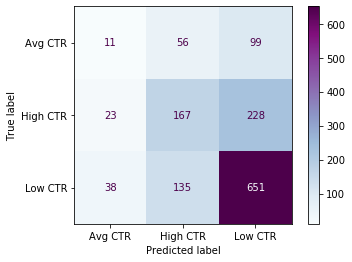

Correctly classified videos from test set: 829, 58.88%
Incorrectly classified videos from test set: 579, 41.12%


In [7]:
sgdc_v2 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', max_df =0.2, ngram_range=(1,3))),
                          ("clf", SGDClassifier(random_state=seed, alpha = 0.00005, 
                                                max_iter=1250, penalty='elasticnet'))])

sgdc_v2.fit(X_train, y_train)

evaluate_model(sgdc_v2, X_test, y_test, X_train, y_train)

The optimized version of the model using the best paramaters from GridSearch resulted in a much higher accuracy for the training set and a lower accuracy for the test set. The model is very overfit and didn't show the improvement I was looking for. 

Let's see if I can obtain paramaters that will optimize my SVC model better:

In [8]:
#SVM Gridsearch

svm_pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', SVC(random_state=seed)),
])


param_grid = [{
    'vect__max_df': (0.2, 0.5),
    'vect__ngram_range': ((1, 2), (1,3), (2,2)), 
    'clf__C':[1,10,100],
    'clf__gamma':[1,0.1,0.001],
    'clf__kernel':['linear','rbf']}]


svm_search = GridSearchCV(svm_pipeline, param_grid, verbose=1)
svm_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', SVC(random_state=293))]),
             param_grid=[{'clf__C': [1, 10, 100], 'clf__gamma': [1, 0.1, 0.001],
                          'clf__kernel': ['linear', 'rbf'],
                          'vect__max_df': (0.2, 0.5),
                          'vect__ngram_range': ((1, 2), (1, 3), (2, 2))}],
             verbose=1)

#### Results:

This one took forever to run! Best params are:

{'clf__C': 1, 
 'clf__gamma': 1,
 'clf__kernel': 'rbf',
 'vect__max_df': 0.5,
 'vect__ngram_range': (1, 2)}

**Best Score:**  0.6030337905075067

In [9]:
display(svm_search.best_params_)
print("Best Score: ", svm_search.best_score_)

{'clf__C': 1,
 'clf__gamma': 1,
 'clf__kernel': 'rbf',
 'vect__max_df': 0.5,
 'vect__ngram_range': (1, 2)}

Best Score:  0.6030337905075067


Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.12      0.01      0.01       166
    High CTR       0.51      0.26      0.35       418
     Low CTR       0.64      0.91      0.75       824

    accuracy                           0.61      1408
   macro avg       0.42      0.39      0.37      1408
weighted avg       0.54      0.61      0.54      1408


---------------

Training Accuracy: 0.8581462435720557
Testing Accuracy: 0.6129261363636364

---------------



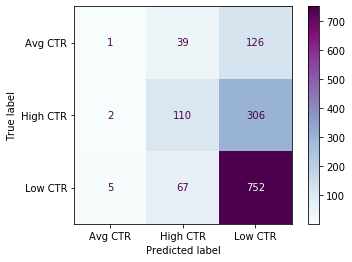

Correctly classified videos from test set: 863, 61.29%
Incorrectly classified videos from test set: 545, 38.71%


In [10]:
svm_v2 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', max_df =0.5, ngram_range=(1,2))),
                          ("clf", SVC(random_state=seed,  gamma= 1, kernel='rbf', C = 1.0))])

svm_v2.fit(X_train, y_train)

evaluate_model(svm_v2, X_test, y_test, X_train, y_train)

This version of the SVM model retained the same accuracy score for the test set but went up in accuracy for the training set. Once again, the model is overfitting.

Looking at the confusion matrices, the models are very biased toward the most prevalent class, LOW CTR. I'm curious to explore further if any words impact that and how to rearrange categories to reduce that bias.

Let's quickly take a look at the current class distribution one more time:

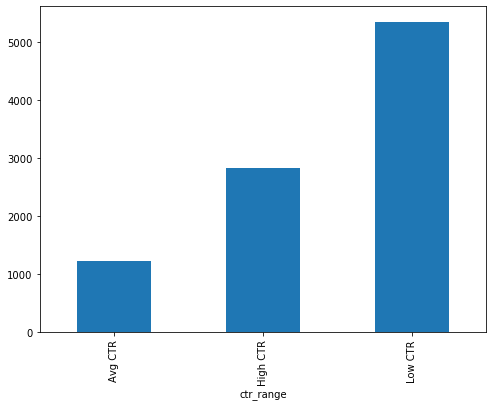

In [11]:
#Visualize class distribution
fig = plt.figure(figsize=(8,6))
df.groupby('ctr_range').clean_title.count().plot.bar(ylim=0)
plt.show()

### Improve Class Bias

In [12]:
#Create numerical representation for each class; I'll need it for a loop that displays correlated words/phrases
col = ['ctr_range', 'lemma_str']
df = df[col]
df = df[pd.notnull(df['lemma_str'])]
df.columns = ['ctr_range', 'lemma_str']
df['ctr_id'] = df['ctr_range'].factorize()[0]
ctr_id_df = df[['ctr_range', 'ctr_id']].drop_duplicates().sort_values('ctr_id')
ctr_to_id = dict(ctr_id_df.values)
id_to_ctr = dict(ctr_id_df[['ctr_id', 'ctr_range']].values)
df.head()

,ctr_range,lemma_str,ctr_id
0,High CTR,hitting female cop,0
1,Avg CTR,naked guy picking girl,1
2,High CTR,flirting nice american female officer norwegian,0
3,Avg CTR,naked guy picking girl usa,1
4,Low CTR,edgard try sell brazilian girl,2


In [13]:
#More preprations to display most correlated uni- and bigrams
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='latin-1', ngram_range=(1, 2))

features = tfidf.fit_transform(df.lemma_str).toarray()

labels = df.ctr_id

In [14]:
def show_corr_words_by_class(features, labels, ):
    '''
    Input: features - > vectorized features as an array
           labels -> labels as a pd.Series
    
    Output: prints out most correlated unigrams, bigrams by class
    
    '''
    
    for ctr_range, ctr_id in sorted(ctr_to_id.items()):
        features_chi2 = chi2(features, labels == ctr_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        print("# '{}':".format(ctr_range))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-5:])))
        print('---------------------------')

In [15]:
show_corr_words_by_class(features, labels)

# 'Avg CTR':
  . Most correlated unigrams:
. mod
. asian
. sesh
. hide
. seek
  . Most correlated bigrams:
. unexpected ending
. agent mission
. secret agent
. world hottest
. hide seek
---------------------------
# 'High CTR':
  . Most correlated unigrams:
. overnight
. survival
. bait
. budget
. fort
  . Most correlated bigrams:
. survival challenge
. world evolution
. jurassic world
. bait prank
. budget challenge
---------------------------
# 'Low CTR':
  . Most correlated unigrams:
. toy
. digger
. jurassic
. evolution
. fort
  . Most correlated bigrams:
. see saw
. budget challenge
. gold digger
. jurassic world
. world evolution
---------------------------


It seems like a lot of the most correlated bigrams for High and Low CTR are the same: 'budget challenge,' 'jurassic world,' and 'world evolution.' No wonder so many of the High CTR videos get classified as Low CTR.

Let's try to remove some of these words:

In [16]:
stopwords1 = ['jurassic','budget','evolution','world', 'prank']
X_train = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords1)]))
X_test = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords1)]))

In [17]:
#SVM
svm_v3 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', )),
                               ("clf", SVC(random_state=seed))
                              ])

svm_v3.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer(decode_error='ignore')),
                ('clf', SVC(random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

     Avg CTR       0.11      0.01      0.01       166
    High CTR       0.54      0.28      0.37       418
     Low CTR       0.64      0.92      0.76       824

    accuracy                           0.62      1408
   macro avg       0.43      0.40      0.38      1408
weighted avg       0.55      0.62      0.55      1408


---------------

Training Accuracy: 0.7838956478113633
Testing Accuracy: 0.6228693181818182

---------------



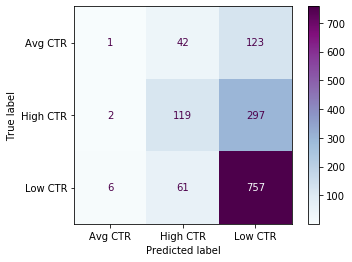

Correctly classified videos from test set: 877, 62.29%
Incorrectly classified videos from test set: 531, 37.71%


In [18]:
evaluate_model(svm_v3, X_test, y_test, X_train, y_train)

Nothing changed. The exact number of actual High CTR got misclassified as Low CTR. 

I want to combine the AVG and HIGH CTR classes to overcome some of the class imbalance, hopefully.

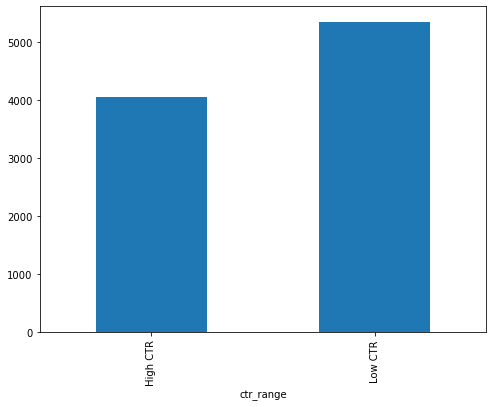

In [19]:
#Let's try this as a binary classification problem by assigning AVG as HIGH CTR
df.loc[df['ctr_range'] == 'Avg CTR', 'ctr_range'] = 'High CTR'

fig = plt.figure(figsize=(8,6))
df.groupby('ctr_range').lemma_str.count().plot.bar(ylim=0)
plt.show()

In [20]:
features2 = tfidf.fit_transform(df.lemma_str).toarray()

labels2 = df.ctr_id

col = ['ctr_range', 'lemma_str']
df = df[col]
df = df[pd.notnull(df['lemma_str'])]
df.columns = ['ctr_range', 'lemma_str']
df['ctr_id'] = df['ctr_range'].factorize()[0]
ctr_id_df = df[['ctr_range', 'ctr_id']].drop_duplicates().sort_values('ctr_id')
ctr_to_id = dict(ctr_id_df.values)
id_to_ctr = dict(ctr_id_df[['ctr_id', 'ctr_range']].values)


#Display correlated words and bigrams for both classes:
show_corr_words_by_class(features2, labels2)

# 'High CTR':
  . Most correlated unigrams:
. overnight
. survival
. bait
. budget
. fort
  . Most correlated bigrams:
. survival challenge
. world evolution
. jurassic world
. bait prank
. budget challenge
---------------------------
# 'Low CTR':
  . Most correlated unigrams:
. mod
. asian
. sesh
. hide
. seek
  . Most correlated bigrams:
. unexpected ending
. agent mission
. secret agent
. world hottest
. hide seek
---------------------------


The most correlated words for both classes are exactly the same. Let's remove them from the corpora.

In [21]:
# Split data into training and test sets
X = df['lemma_str']
y = df['ctr_range']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)

#Checking class balance in training set 
y_train.value_counts(1) * 100

Low CTR     56.641164
High CTR    43.358836
Name: ctr_range, dtype: float64

In [22]:
stopwords2 = ['toy','digger','jurassic','evolution','fort','prank']
X_train2 = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords2)]))
X_test2 = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords2)]))

In [23]:
#SVM v.4 
svm_v4 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', )),
                               ("clf", SVC(random_state=seed))
                              ])

svm_v4.fit(X_train2, y_train)


Pipeline(steps=[('vectorizer', TfidfVectorizer(decode_error='ignore')),
                ('clf', SVC(random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.60      0.48      0.54       584
     Low CTR       0.68      0.77      0.72       824

    accuracy                           0.65      1408
   macro avg       0.64      0.63      0.63      1408
weighted avg       0.64      0.65      0.64      1408


---------------

Training Accuracy: 0.8767088925122287
Testing Accuracy: 0.6512784090909091

---------------



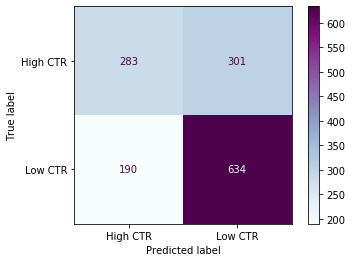

Correctly classified videos from test set: 917, 65.13%
Incorrectly classified videos from test set: 491, 34.87%


In [24]:
evaluate_model(svm_v4, X_test2, y_test, X_train2, y_train)

There's a slight improvement. 65.13% accuracy on trainign set if I do binary classification and remove some of the overlapping correlated terms.

Let's fit the SGDC model with the paramaters GridSearch suggested above.

In [25]:
#SGDC V.3 
sgdc_v3 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_v3.fit(X_train2, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.61      0.46      0.53       584
     Low CTR       0.68      0.79      0.73       824

    accuracy                           0.66      1408
   macro avg       0.64      0.63      0.63      1408
weighted avg       0.65      0.66      0.65      1408


---------------

Training Accuracy: 0.8823529411764706
Testing Accuracy: 0.6555397727272727

---------------



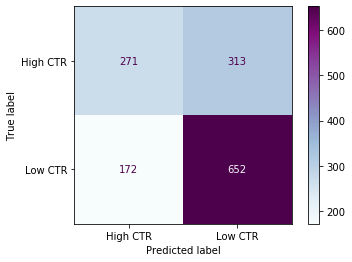

Correctly classified videos from test set: 923, 65.55%
Incorrectly classified videos from test set: 485, 34.45%


In [26]:
evaluate_model(sgdc_v3, X_test2, y_test, X_train2, y_train)

A tiny bit higher in accuracy - 65.55%

In [27]:
#Let's also try out Naive Bayes again:

nb_2_pipeline = Pipeline(steps=[("ttf-idf", TfidfVectorizer(decode_error= 'ignore')),
                                ("nb", MultinomialNB(alpha=0.5))])

nb_2_pipeline.fit(X_train2, y_train)

Pipeline(steps=[('ttf-idf', TfidfVectorizer(decode_error='ignore')),
                ('nb', MultinomialNB(alpha=0.5))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.59      0.42      0.49       584
     Low CTR       0.66      0.79      0.72       824

    accuracy                           0.64      1408
   macro avg       0.62      0.61      0.61      1408
weighted avg       0.63      0.64      0.62      1408


---------------

Training Accuracy: 0.7670889251222878
Testing Accuracy: 0.6370738636363636

---------------



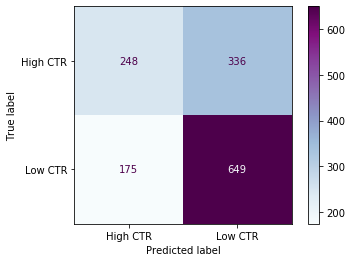

Correctly classified videos from test set: 897, 63.71%
Incorrectly classified videos from test set: 511, 36.29%


In [28]:
evaluate_model(nb_2_pipeline, X_test2, y_test, X_train2, y_train)

It has the lowest accuracy of the three. 

In [29]:
rf2_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                                ("rf", RandomForestClassifier())])

rf2_pipeline.fit(X_train2, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('rf', RandomForestClassifier())])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.55      0.55      0.55       584
     Low CTR       0.68      0.69      0.68       824

    accuracy                           0.63      1408
   macro avg       0.62      0.62      0.62      1408
weighted avg       0.63      0.63      0.63      1408


---------------

Training Accuracy: 0.9608679292612567
Testing Accuracy: 0.6299715909090909

---------------



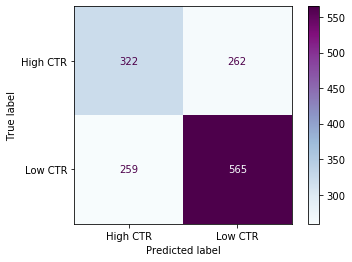

Correctly classified videos from test set: 887, 63.0%
Incorrectly classified videos from test set: 521, 37.0%


In [30]:
evaluate_model(rf2_pipeline, X_test2, y_test, X_train2, y_train)

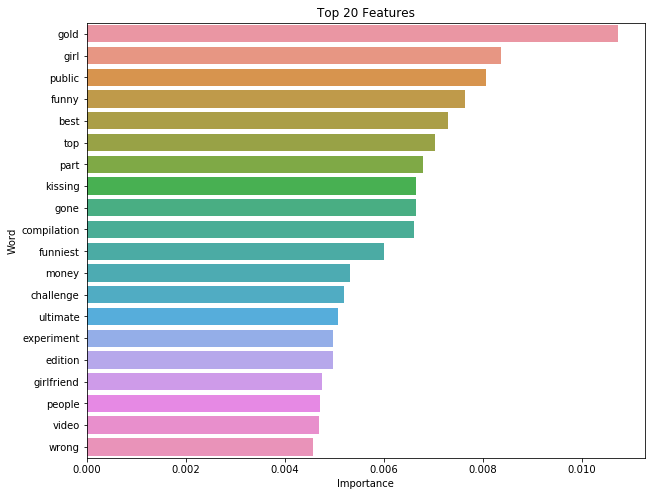

In [31]:
important_feats = pd.Series(rf2_pipeline['rf'].feature_importances_,
                      index=rf2_pipeline['vectorizer'].get_feature_names())

top_20_feats = important_feats.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=top_20_feats, y=top_20_feats.index)
plt.title('Top 20 Features')
plt.ylabel('Word')
plt.xlabel('Importance')
plt.show()

Since the RF model is very overfit, let's run it again by taking out the top 10 most important words.

In [32]:
stopwords3 = ['gold','public','girl','funny','best','top','compilation','gone','kissing','part']
X_train3 = X_train.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords3)]))
X_test3 = X_test.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords3)]))

In [33]:
rf3_pipeline = Pipeline(steps=[("vectorizer", CountVectorizer(decode_error= 'ignore')),
                                ("rf", RandomForestClassifier())])

rf3_pipeline.fit(X_train3, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(decode_error='ignore')),
                ('rf', RandomForestClassifier())])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.56      0.53      0.55       584
     Low CTR       0.68      0.70      0.69       824

    accuracy                           0.63      1408
   macro avg       0.62      0.62      0.62      1408
weighted avg       0.63      0.63      0.63      1408


---------------

Training Accuracy: 0.9533425310422676
Testing Accuracy: 0.6313920454545454

---------------



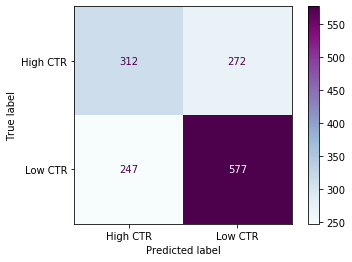

Correctly classified videos from test set: 889, 63.14%
Incorrectly classified videos from test set: 519, 36.86%


In [34]:
evaluate_model(rf3_pipeline, X_test3, y_test, X_train3, y_train)

Ok, the RF model improved very slightly. Let's see if taking out these words will also improve my best performing model so far - the SGDC:

In [35]:
#SGDC V.4 
sgdc_v4 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_v4.fit(X_train3, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.62      0.46      0.53       584
     Low CTR       0.68      0.80      0.73       824

    accuracy                           0.66      1408
   macro avg       0.65      0.63      0.63      1408
weighted avg       0.65      0.66      0.65      1408


---------------

Training Accuracy: 0.8783393954596764
Testing Accuracy: 0.6569602272727273

---------------



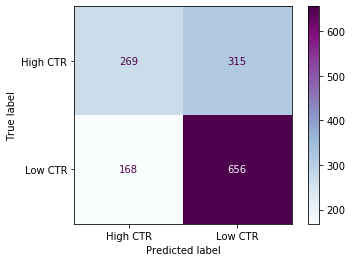

Correctly classified videos from test set: 925, 65.7%
Incorrectly classified videos from test set: 483, 34.3%


In [36]:
evaluate_model(sgdc_v4, X_test3, y_test, X_train3, y_train)

**SGDC v.4 (65.69%)** vs SGDC v. 3 (65.55%) - very slight improvement! 

Lastly, I want to shorten the titles to only include complete words up to the 60th character. Everything else gets technically cut-off when YouTube displays the videos in some parts of their platform.

In [37]:
def shorten_title(title, suffix='...'):
    if len(title) <= 60:
        return title
    else:
        return ' '.join(title[:60+1].split(' ')[0:-1]) + suffix

In [38]:
X_train_short = X_train3.apply(shorten_title)
X_test_short = X_test3.apply(shorten_title)

In [39]:
#SGDC V.5 
sgdc_v5 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_v5.fit(X_train_short, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.62      0.46      0.53       584
     Low CTR       0.68      0.80      0.73       824

    accuracy                           0.66      1408
   macro avg       0.65      0.63      0.63      1408
weighted avg       0.65      0.66      0.65      1408


---------------

Training Accuracy: 0.8782139721560266
Testing Accuracy: 0.6590909090909091

---------------



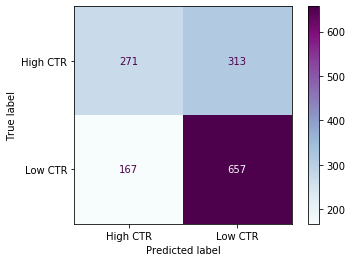

Correctly classified videos from test set: 928, 65.91%
Incorrectly classified videos from test set: 480, 34.09%


In [40]:
evaluate_model(sgdc_v5, X_test3, y_test, X_train3, y_train)

### Create more classes

In [41]:
#Read organized dataset as a DataFrame
main = pd.read_csv('data/finalized/main_dataset.csv')

#Slice DF with needed columns only
vids = main[['video_title','ctr']]

#Pull stats on CTR
vids.ctr.describe()

count    9410.000000
mean        4.553729
std         3.572096
min         0.000000
25%         1.660000
50%         3.800000
75%         6.770000
max        50.000000
Name: ctr, dtype: float64

In [42]:
#Let's store the standard stopwords list from NLTK into a variable 
stop = stopwords.words('english')

new_stopwords = stop+stopwords3

def lemmatize_title(title):
    '''
    Input: a video title as a list of tokens
    
    Output: a list of lemmatized tokens
    
    '''
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in title]

In [43]:
#Let's preprocess all titles again
vids.video_title = vids.video_title.apply(lambda x: preprocess_title(x, tokenize=True, stopwords=new_stopwords))

vids.video_title = vids.video_title.apply(lemmatize_title)

vids = vids[~vids.video_title.str.len().eq(0)]

vids.video_title = [' '.join(map(str,l)) for l in vids.video_title]

vids.head()

,video_title,ctr
0,hitting female cop,10.07
1,naked guy picking girl,5.75
2,flirting nice american female officer norwegian,11.23
3,naked guy picking girl usa,4.68
4,edgard try sell brazilian,3.86


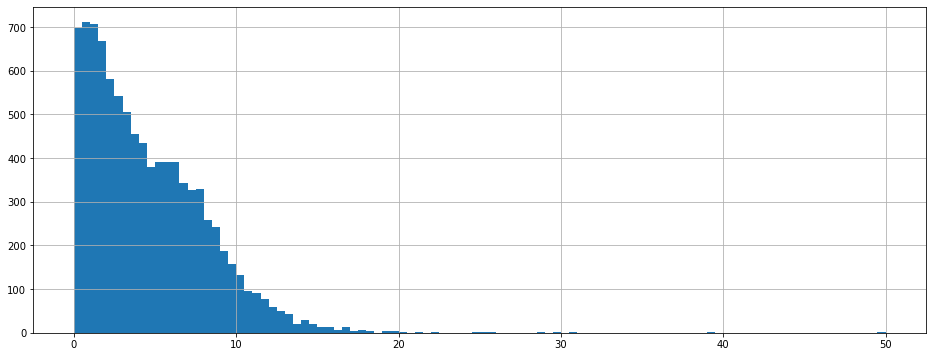

In [44]:
#To get a better idea of what options I have to build new classes, let's look at a histogram 
vids.ctr.hist(figsize=(16,6), bins=100)

In [45]:
#New Classes:

def ctr_range(df):
    if df['ctr'] < 1.00:
        return 'Under 1%'
    elif 1.00 < df['ctr'] < 3.00:
        return 'Between 2-3%'
    elif 3.00 < df['ctr'] < 5.00:
        return 'Between 3-5%'
    elif 5.00 < df['ctr'] < 8.00:
        return 'Between 5-8%'
    elif df['ctr'] > 8:
        return 'Over 8%'
    else:
        return 'Undefined'

#Add the class to each video in the DataFrame
vids['ctr_range'] = vids.apply(ctr_range, axis=1)

#Preview DataFrame
vids.head(7)

,video_title,ctr,ctr_range
0,hitting female cop,10.07,Over 8%
1,naked guy picking girl,5.75,Between 5-8%
2,flirting nice american female officer norwegian,11.23,Over 8%
3,naked guy picking girl usa,4.68,Between 3-5%
4,edgard try sell brazilian,3.86,Between 3-5%
5,back carnival brazil trip,2.51,Between 2-3%
6,guy watch gay lovemaking unplugged headphone,5.53,Between 5-8%


In [46]:
#Drop the videos missing CTR that were classified as "undefined"
vids.drop(vids.loc[vids['ctr_range']=="Undefined"].index, inplace=True)

#Let's look at the normalized class balance
vids.ctr_range.value_counts(normalize=True)

Between 2-3%    0.264637
Between 5-8%    0.231410
Between 3-5%    0.188248
Over 8%         0.165171
Under 1%        0.150534
Name: ctr_range, dtype: float64

In [47]:
# Split data into training and test sets
X = vids['video_title']
y = vids['ctr_range']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X, y, test_size=0.15, random_state=seed)

#Checking class balance in training set 
y_train_new.value_counts(1) * 100

Between 2-3%    26.407743
Between 5-8%    22.951232
Between 3-5%    18.991956
Over 8%         16.465561
Under 1%        15.183509
Name: ctr_range, dtype: float64

In [48]:
#SGDC V.6 
sgdc_v6 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_v6.fit(X_train_new, y_train_new)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

Between 2-3%       0.33      0.53      0.41       376
Between 3-5%       0.23      0.15      0.18       251
Between 5-8%       0.35      0.40      0.37       340
     Over 8%       0.37      0.21      0.26       236
    Under 1%       0.30      0.18      0.22       201

    accuracy                           0.33      1404
   macro avg       0.32      0.29      0.29      1404
weighted avg       0.32      0.33      0.31      1404


---------------

Training Accuracy: 0.8036701860231272
Testing Accuracy: 0.3262108262108262

---------------



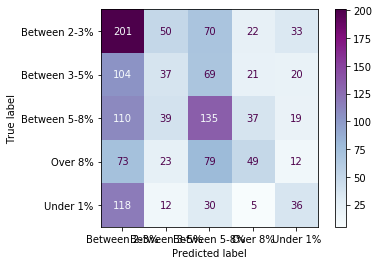

Correctly classified videos from test set: 458, 32.62%
Incorrectly classified videos from test set: 946, 67.38%


In [49]:
evaluate_model(sgdc_v6, X_test_new, y_test_new, X_train_new, y_train_new)

This isn't going well. It feels like I might be in a better position if I go for binary classification.

In [50]:
def change_range(df):
    if df['ctr'] < 4.00:
        return 'Low CTR'
    else:
        return 'High CTR'
    

In [51]:
vids['ctr_range'] = vids.apply(change_range, axis=1)

In [52]:
# Split data into training and test sets
X2 = vids['video_title']
y2 = vids['ctr_range']

X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X2, y2, test_size=0.15, random_state=seed)

#Checking class balance in training set 
y_train_bi.value_counts(1) * 100

Low CTR     51.960784
High CTR    48.039216
Name: ctr_range, dtype: float64

In [53]:
#SGDC V.7 
sgdc_v7 = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_v7.fit(X_train_bi, y_train_bi)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', SGDClassifier(loss='log', random_state=293))])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.66      0.57      0.61       704
     Low CTR       0.62      0.71      0.66       700

    accuracy                           0.64      1404
   macro avg       0.64      0.64      0.64      1404
weighted avg       0.64      0.64      0.64      1404


---------------

Training Accuracy: 0.8903971845148315
Testing Accuracy: 0.6396011396011396

---------------



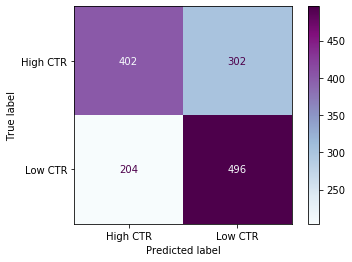

Correctly classified videos from test set: 898, 63.96%
Incorrectly classified videos from test set: 506, 36.04%


In [54]:
evaluate_model(sgdc_v7, X_test_bi, y_test_bi, X_train_bi, y_train_bi)

In [55]:
#Let's explore what would be the optimal cut-off point for binary classification

for n in (2,3,4,5,6) :
    
    def new_range(df):
        if df['ctr'] < n:
            return 'Low CTR'
        else:
            return 'High CTR'
    
    vids['ctr_range'] = vids.apply(new_range, axis=1)
    
    # Split data into training and test sets
    X3 = vids['video_title']
    y3 = vids['ctr_range']

    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X3, y3, test_size=0.15, random_state=seed)
    
    #SGDC  
    sgdc_model = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

    sgdc_model.fit(X_train_l, y_train_l)

    # Get predictions
    y_hat_train = sgdc_model.predict(X_train_l)
    y_hat_test = sgdc_model.predict(X_test_l)

    print('\n---------------\n')
    print(f'For threshold {n}:')
    print('\n---------------\n')
    print('Training Accuracy:', accuracy_score(y_train_l, y_hat_train))
    print('Testing Accuracy:', accuracy_score(y_test_l, y_hat_test))


---------------

For threshold 2:

---------------

Training Accuracy: 0.7903469079939668
Testing Accuracy: 0.7229344729344729

---------------

For threshold 3:

---------------

Training Accuracy: 0.8552036199095022
Testing Accuracy: 0.6566951566951567

---------------

For threshold 4:

---------------

Training Accuracy: 0.8903971845148315
Testing Accuracy: 0.6396011396011396

---------------

For threshold 5:

---------------

Training Accuracy: 0.8632478632478633
Testing Accuracy: 0.6481481481481481

---------------

For threshold 6:

---------------

Training Accuracy: 0.8132227249874309
Testing Accuracy: 0.7029914529914529


Let's try XGBoost for binary classifcation, too:

In [56]:
#XGB Model
xgb = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", xgb.XGBClassifier())
                              ])

xgb.fit(X_train_bi, y_train_bi)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(decode_error='ignore', ngram_range=(1, 3))),
                ('clf', XGBClassifier())])

Classification Report: 

              precision    recall  f1-score   support

    High CTR       0.61      0.56      0.58       704
     Low CTR       0.59      0.63      0.61       700

    accuracy                           0.60      1404
   macro avg       0.60      0.60      0.60      1404
weighted avg       0.60      0.60      0.60      1404


---------------

Training Accuracy: 0.653720462543992
Testing Accuracy: 0.5982905982905983

---------------



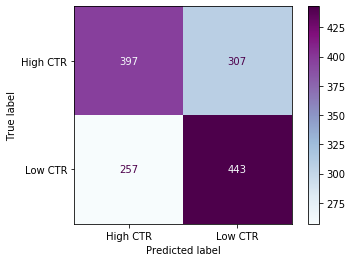

Correctly classified videos from test set: 840, 59.83%
Incorrectly classified videos from test set: 564, 40.17%


In [57]:
evaluate_model(xgb, X_test_bi, y_test_bi, X_train_bi, y_train_bi)

### Make a Prediction

In [58]:
#FINAL MODEL:

def new_range(df):
        if df['ctr'] < 6:
            return 'Low CTR'
        else:
            return 'High CTR'
    
vids['ctr_range'] = vids.apply(new_range, axis=1)

X_final = vids['video_title']
y_final = vids['ctr_range']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final, y_final, test_size=0.15, random_state=seed)
    
#SGDC  
sgdc_final = Pipeline(steps=[("vectorizer", TfidfVectorizer(decode_error='ignore', ngram_range=(1,3) )),
                               ("clf", SGDClassifier(random_state=seed, loss='log'))
                              ])

sgdc_final.fit(X_train_f, y_train_f)

# Get predictions
y_hat_train_f = sgdc_final.predict(X_train_f)
y_hat_test_f = sgdc_final.predict(X_test_f)

print('Training Accuracy:', accuracy_score(y_train_f, y_hat_train_f))
print('Testing Accuracy:', accuracy_score(y_test_f, y_hat_test_f))

Training Accuracy: 0.8132227249874309
Testing Accuracy: 0.7029914529914529


In [59]:
#Before I make some predictions, let's import a few things:
from IPython.display import Image
from IPython.core.display import HTML 

In [60]:
#Prediction #1
sgdc_final.predict([preprocess_title('ULTIMATE HIDDEN SNACK PANTRY! *Secret Entrance*')])

array(['High CTR'], dtype='<U8')

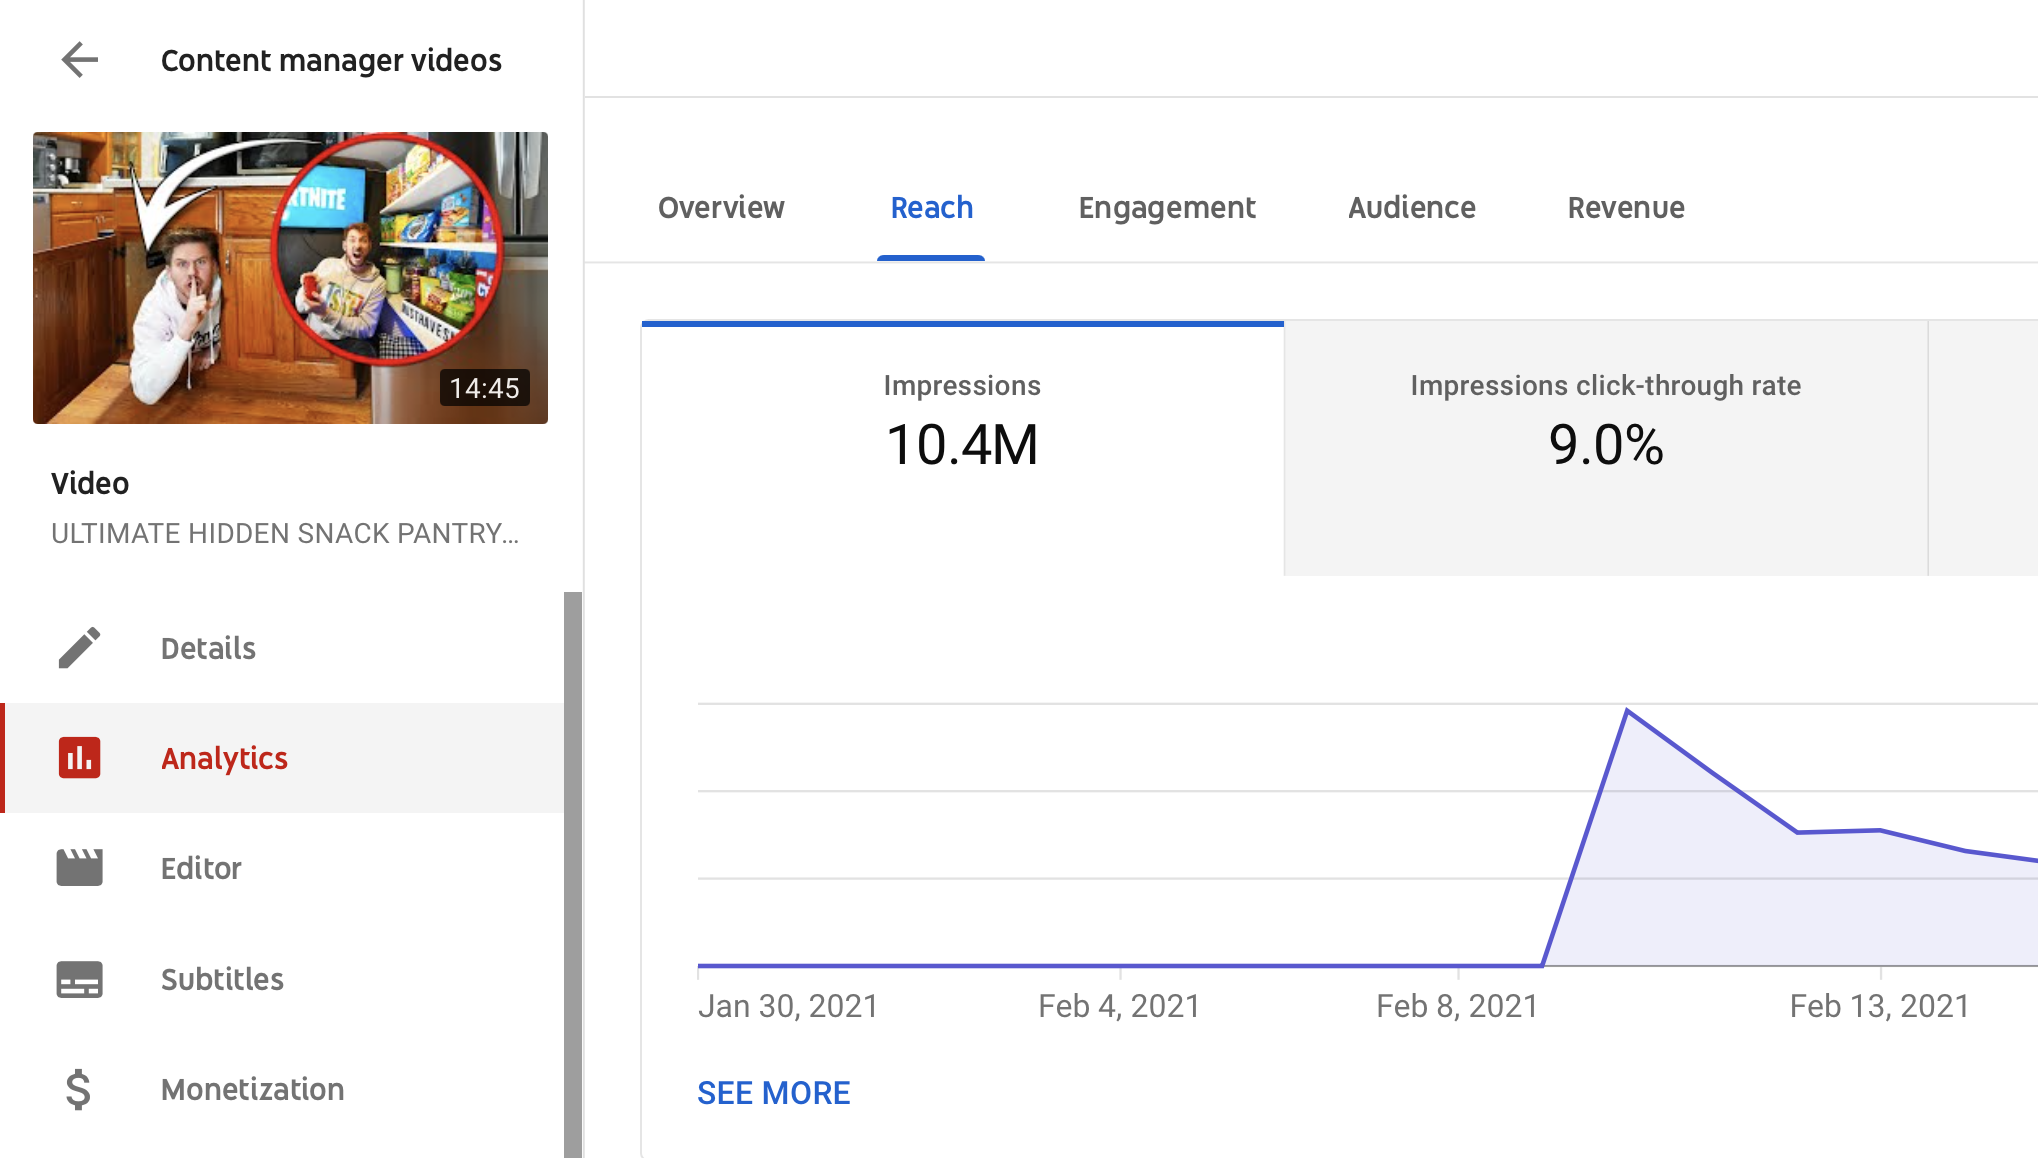

In [61]:
Image(filename = 'images/prediction-1.png', width=650, height=500)

In [62]:
#PREDICTION #2
sgdc_final.predict([preprocess_title('Extremely Difficult TRY NOT TO LAUGH Challenge 😂🔥😹')])

array(['Low CTR'], dtype='<U8')

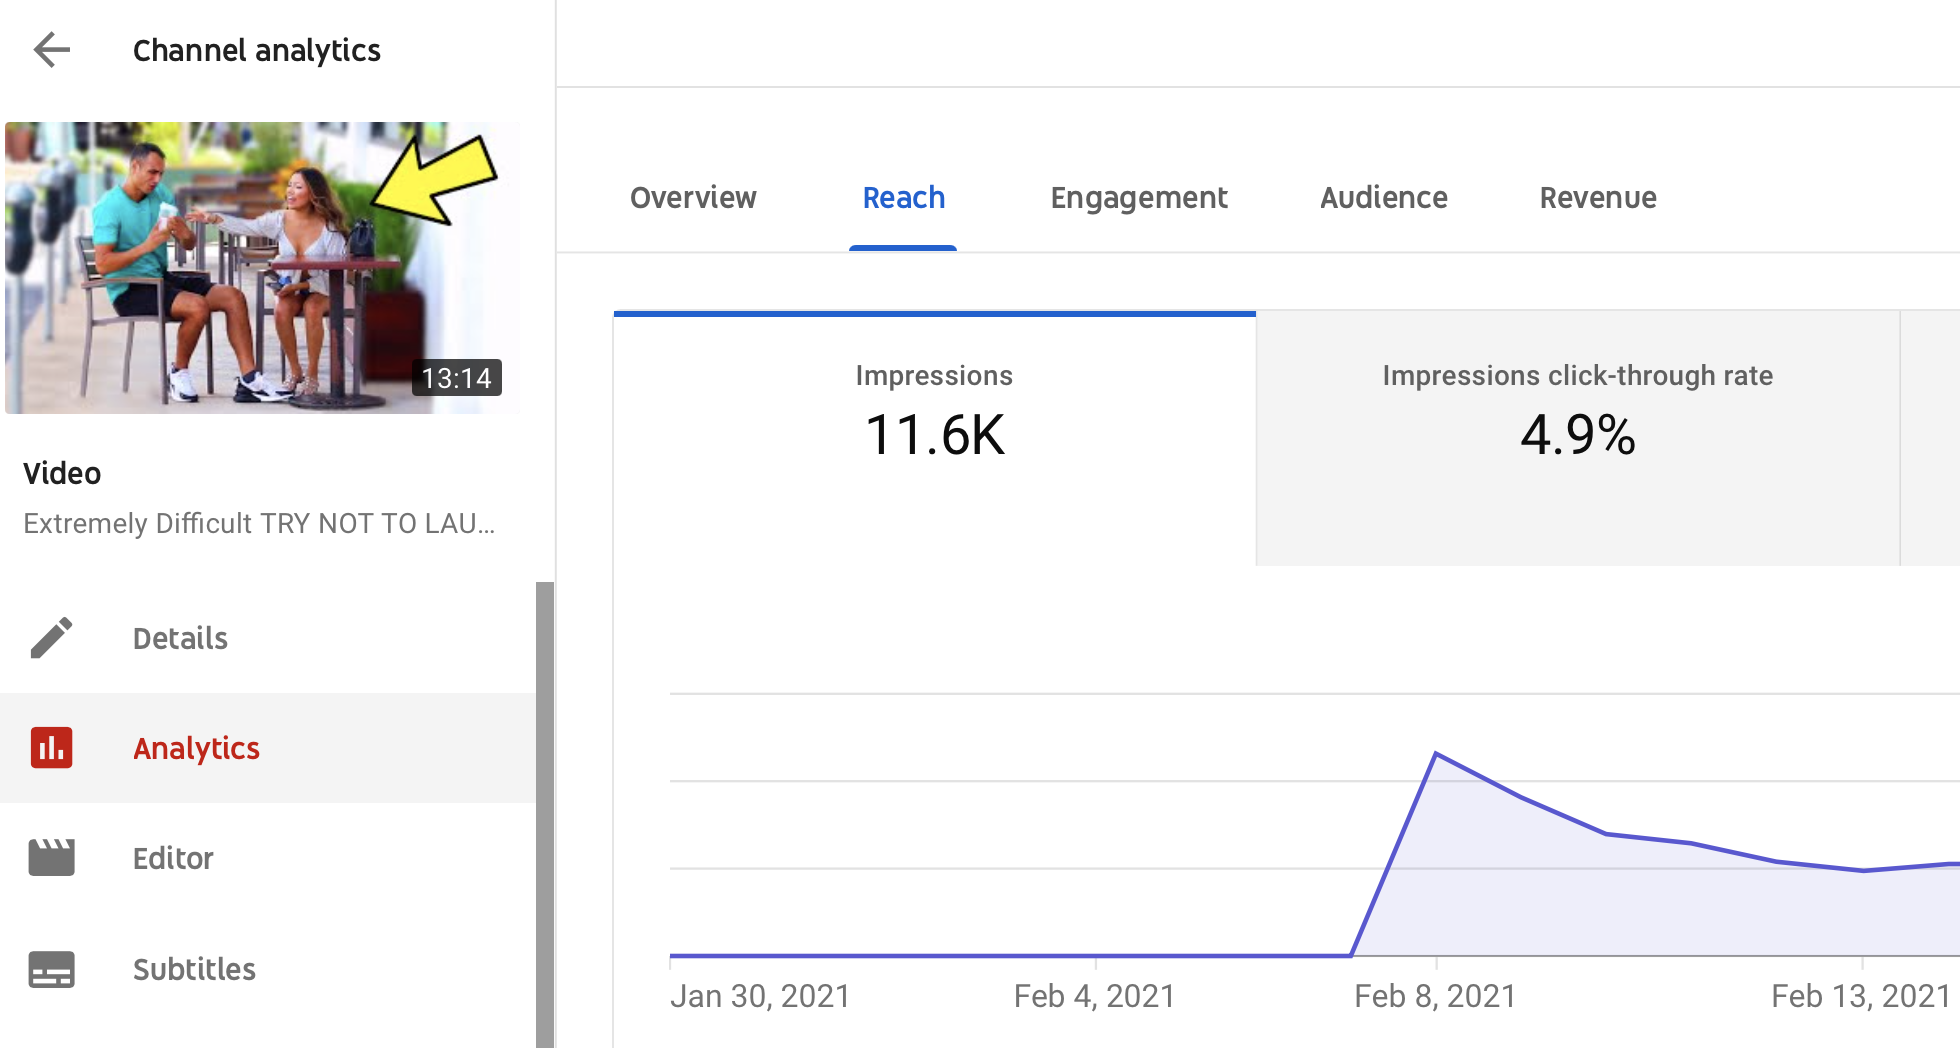

In [63]:
Image(filename = 'images/prediction-2.png', width=650, height=500)

### FUTURE WORK:

* Create a classifier that predicts CTR based on
thumbnails.
* Train current model on CTR for different time
frames: first 48 hours, first 7 days, etc.
* Train current model with titles in different
languages.
* Train current model on titles fromdifferent
video genres such as Beauty, Lifestyle,
Gaming, etc.
